<h1><center><b><font color='#dfa2af'> Social-Media Friends Recommendation.</font></b></center></h1>


<!-- ![Social Media Link]("https://www.brandignity.com/wp-content/uploads/2011/03/website-communication-goals.jpgf"align="center")

! <img src="https://www.brandignity.com/wp-content/uploads/2011/03/website-communication-goals.jpgf" align="center"> -->

<figure>
  <img src="https://img.freepik.com/free-vector/social-networks-communication-concept_1284-14087.jpg?w=2000" alt=Trulli style="Width:100%">
  <figcaption align="center"> </figcaption>
</figure>


![Social Media Link](https://www.brandignity.com/wp-content/uploads/2011/03/website-communication-goals.jpg)

## <font color='#4682B4'>  1. Business Problem </font>
<h3> Description </h3>

This Project is based on social media link prediction whether two users are going to be friend in future or not.

**OverView** 
* An introduction to link prediction, how it works, and where 
you can use it in the real-world
* Learn about the importance of Link Prediction on social media
* Build your first Link Prediction model for a Facebook use case using Python

## <font color='#4682B4'>  2. Loading Required Libraries</font>

In [ ]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# importing requierd libraries
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')

## <font color='#4682B4'>  3. Data Set info</font>


Data Columns (Total 2 Columns)
*   source_node
*   destination



In [ ]:
# load nodes details
with open("fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [ ]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 857629.09it/s]


In [ ]:
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


## <font color='#4682B4'>4. Data Analysis </font>

In [ ]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [ ]:
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import networkx as nx


In [ ]:

# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [ ]:
adj_G.shape

(620, 620)

In [ ]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:07<00:00, 79.78it/s] 


In [ ]:
len(all_unconnected_pairs)

19018

In [ ]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [ ]:

initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:16<00:00, 130.70it/s]


In [ ]:
len(omissible_links_index)

1483

In [ ]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [ ]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

In [ ]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [ ]:
# !pip install node2vec

In [ ]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


## <font color='#4682B4'>5. EDA</font>

In [ ]:
Myfriends_Network = pd.read_csv("/content/Myfriends_Network_Train.csv")
Myfriends_Network

,Source Node,Destination Node
0,Yash,Omkar
1,Omkar,Sahil
2,Sahil,Minal
3,Aatif,Achal
4,Akash,Aatif
5,Yash,Ujwala
6,Omkar,Sahil
7,Sahil,Yash
8,Shreya,Vaishnavi
9,Minal,Sakshi


In [ ]:
# list of values of 'Marks' column
Source_list = Myfriends_Network['Source Node'].tolist()
Destination_list = Myfriends_Network['Destination Node'].tolist()
  
# show the list
print(Source_list)
print(Destination_list)

['Yash', 'Omkar', 'Sahil', 'Aatif', 'Akash', 'Yash', 'Omkar', 'Sahil', 'Shreya', 'Minal', 'Ujwala', 'Achal', 'Shreya', 'Sakshi', 'Vaishnavi', 'Yash', 'Sahil', 'Omkar', 'Aatif', 'Aatif', 'Aatif', 'Achal', 'Sakshi', 'Minal', 'Ujwala', 'Vaishnavi', 'Omkar', 'Sakshi', 'Sahil', 'Darshan', 'Darshan', 'Ujwala', 'Yash', 'Yash', 'Yash', 'Aatif', 'Ujwala', 'Yash', 'Sahil', 'Omkar', 'Ujwala', 'Darshan', 'Omkar', 'Ujwala', 'Yash', 'Omkar', 'Minal', 'Achal', 'Yash']
['Omkar', 'Sahil', 'Minal', 'Achal', 'Aatif', 'Ujwala', 'Sahil', 'Yash', 'Vaishnavi', 'Sakshi', 'Omkar', 'Shreya', 'Omkar', 'Shreya', 'Omkar', 'Sahil', 'Ujwala', 'Shreya', 'Yash', 'Darshan', 'Ujwala', 'Shreya', 'Sahil', 'Yash', 'Minal', 'Aatif', 'Yash', 'Yash', 'Darshan', 'Omkar', 'Yash', 'Vaishnavi', 'Minal', 'Achal', 'Vaishnavi', 'Yash', 'Yash', 'Shreya', 'Minal', 'Minal', 'Sahil', 'Vaishnavi', 'Achal', 'Aatif', 'Aatif', 'Darshan', 'Achal', 'Ujwala', 'Ujwala']


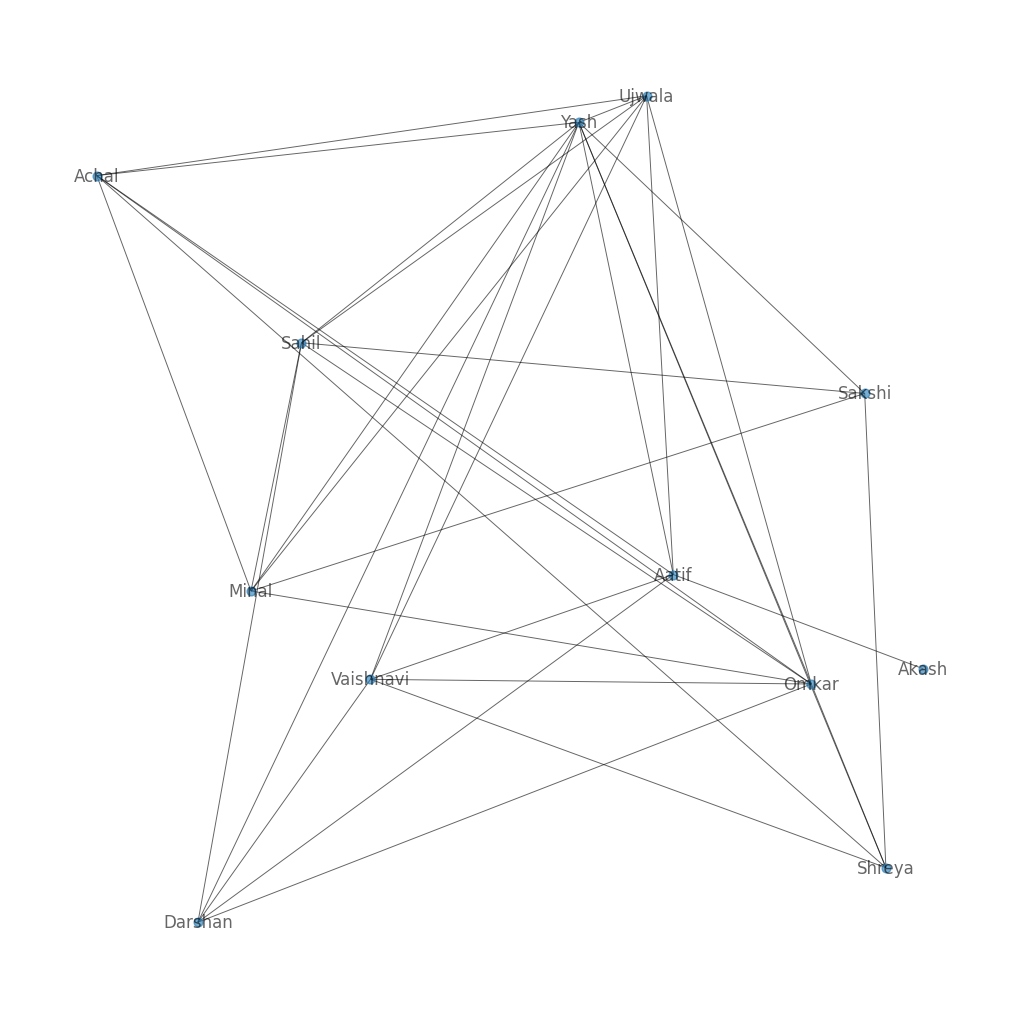

In [ ]:
# create graph
G = nx.from_pandas_edgelist(Myfriends_Network,"Source Node", "Destination Node", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=True,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7,)

plt.show()

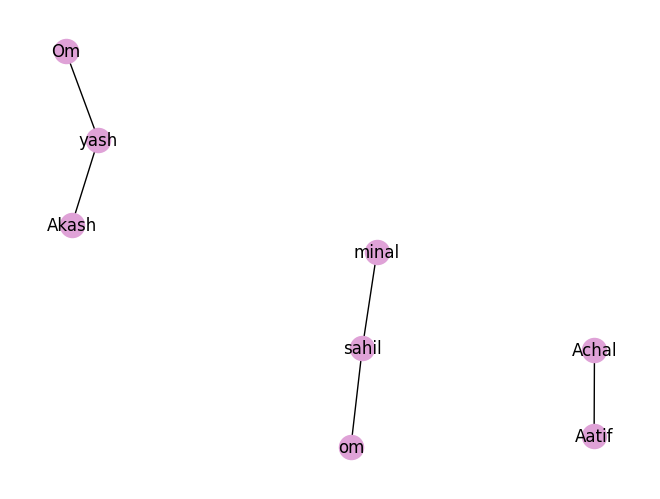

In [ ]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
 
g = nx.Graph()
 
g.add_edge('yash', 'Om')
g.add_edge('om', 'sahil')
g.add_edge('sahil','minal')
g.add_edge('Aatif', 'Achal')
g.add_edge('yash', 'Akash')
 
nx.draw(g, with_labels = True,node_color='#dfa2d7')
plt.savefig("filename.png")

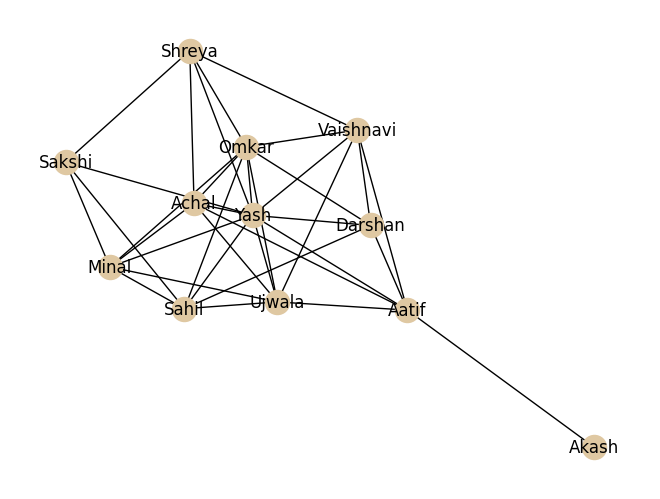

<Figure size 640x480 with 0 Axes>

In [ ]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
# Build your graph
G=nx.from_pandas_edgelist(Myfriends_Network, 'Source Node', 'Destination Node')
# Plot it
nx.draw(G, with_labels=True,node_color='#dfc8a2')
plt.show()
plt.savefig("filename.png")

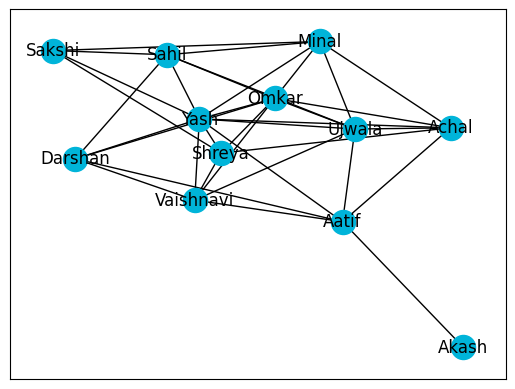

In [ ]:
import math
# G = nx.from_pandas_edgelist(4.source='Source',Target='Destination')
G=nx.from_pandas_edgelist(Myfriends_Network, 'Source Node', 'Destination Node')
nx.draw_networkx(G,with_labels=True,node_color='#00b4d9')
phi = (1+math.sqrt(24))/2.0 # largest eigenvalue of adj matrix
# centrality = nx.katz_centrality(G,1/phi-0.01)
# for n,c in sorted(centrality.items()):
  # print("%d %0.2f"%(n,c))

In [ ]:
# load edges (or links)
with open("/content/Myfriends_Network_Train.csv") as f:
    fb_links = f.read().splitlines() 

# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})
fb_df=fb_df.iloc[1: , :]

100%|██████████| 50/50 [00:00<00:00, 111491.33it/s]


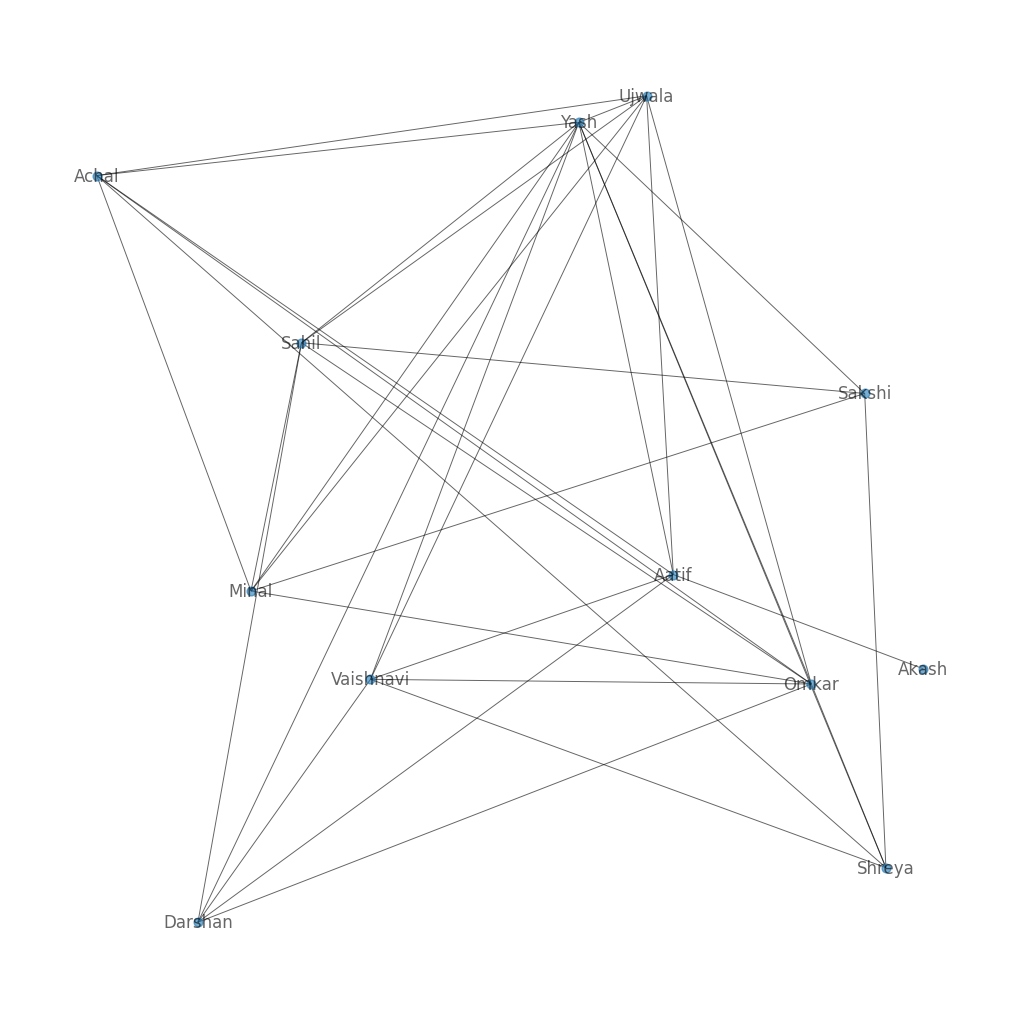

In [ ]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=True,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

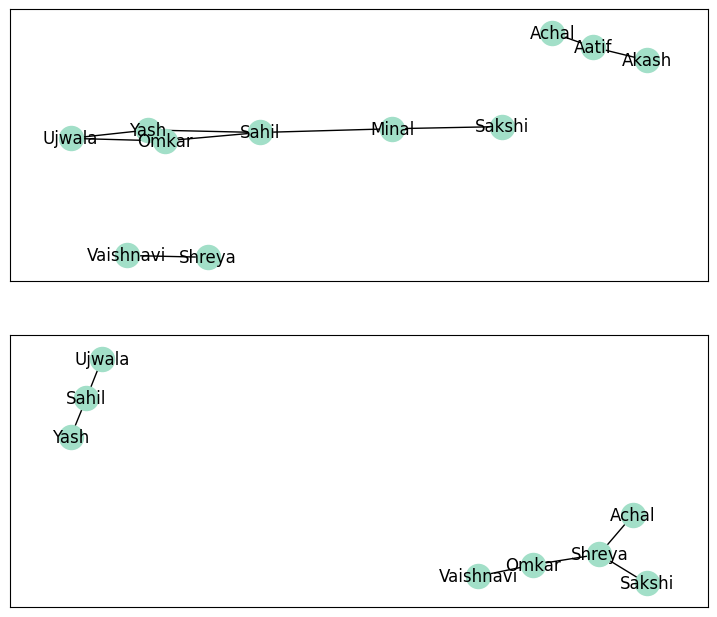

In [ ]:
import networkx as nx 
import matplotlib.pyplot as plt
  
G = nx.Graph()
  
plt.figure(figsize =(9, 12))
G.add_edges_from([('Yash','Omkar'), ('Omkar','Sahil'), ('Sahil','Minal'), ('Aatif','Achal'), ('Akash','Aatif'), ('Yash','Ujwala'), 
                         ('Omkar','Sahil'), ('Sahil','Yash'), ('Shreya','Vaishnavi'), ('Minal','Sakshi'), ('Ujwala','Omkar')])
# G.add_edges_from([(1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), 
#                          (4, 5), (4, 6), (5, 7), (5, 8), (7, 8)])
  
# First Graph created
plt.subplot(311)
nx.draw_networkx(G,node_color='#a2dfc8')
  
H = nx.Graph()
H.add_edges_from([('Achal','Shreya'), ('Shreya','Omkar'), ('Sakshi','Shreya'),
                  ('Vaishnavi','Omkar'), ('Yash','Sahil'), ('Sahil','Ujwala')])
  
# Second Graph created
plt.subplot(312)
nx.draw_networkx(H,node_color='#a2dfc8')#,font_color='whitesmoke')
  
  
# I = nx.union(G, H)
# plt.subplot(313)
# nx.draw_networkx(I)

## <font color='#4682B4'>6. Preprocessing</font>

In [ ]:
x = [(n2w_model.wv[str(i)]+n2w_model.wv[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

In [ ]:
x = [(n2w_model.wv[str(i)]+n2w_model.wv[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

<h4> <font color='#87CEEB  '>Train Test Split </h4>

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.2, 
                                                random_state = 42)

In [ ]:
print('Train data shape {} {}'.format(xtrain.shape, ytrain.shape))
print('Test data shape {} {}'.format(xtest.shape, ytest.shape))

Train data shape (16400, 100) (16400,)
Test data shape (4101, 100) (4101,)


## <font color='#4682B4'> 7. Machine Learning Models </h2></font>

In [ ]:
# dictionary to store accuracy and roc score for each model
score = {}

<h3> Logistic Regression </h3>

<h4> Hyperparameter tuning Logistic Regression</h4>

In [ ]:
parameters = {'C':[(10**i)*x for i in range(-4, 1) for x in [1,3,5]]}

model_LR = LogisticRegression(class_weight='balanced')
clf_LR = RandomizedSearchCV(model_LR, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf_LR.fit(xtrain, ytrain)
print('Best parameters:  {}'.format(clf_LR.best_params_))
print('Best score: {}'.format(clf_LR.best_score_))

Best parameters:  {'C': 1}
Best score: 0.8034654091025313


<h4>Training Logistic Regression with best hyperparameters </h4>

**************************************************
Train AUC: 0.826
Test AUC: 0.813
**************************************************
Train Accuracy: 0.739
Test Accuracy: 0.745


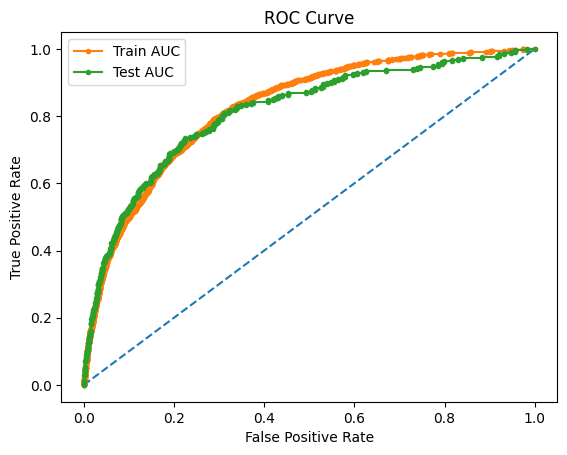

In [ ]:
from sklearn.metrics import log_loss

model_LR = LogisticRegression(C=0.5, class_weight='balanced', n_jobs=-1)
model_LR.fit(xtrain, ytrain)
y_probs_train = model_LR.predict_proba(xtrain)
y_probs_test = model_LR.predict_proba(xtest)
y_predicted_train = model_LR.predict(xtrain)
y_predicted_test = model_LR.predict(xtest)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_test = y_probs_test[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(ytrain, y_probs_train)
test_auc = roc_auc_score(ytest, y_probs_test)
train_acc = accuracy_score(ytrain, y_predicted_train)
test_acc = accuracy_score(ytest, y_predicted_test)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('Test AUC: %.3f' % test_auc)
print('*'*50)
print('Train Accuracy: %.3f' % train_acc)
print('Test Accuracy: %.3f' % test_acc)

score['Logistic Regression'] = [test_auc, test_acc]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(ytrain, y_probs_train)
test_fpr, test_tpr, test_thresholds = roc_curve(ytest, y_probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(test_fpr, test_tpr, marker='.', label='Test AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
# lr = LogisticRegression(class_weight="balanced")

# lr.fit(xtrain, ytrain)

In [ ]:
# predictions = lr.predict_proba(xtest)

In [ ]:
# roc_auc_score(ytest, predictions[:,1])

<h3> Lightgbm </h3>

In [ ]:

pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import GridSearchCV


<h4> Hyperparameter tuning Lightgbm</h4>

In [ ]:
import lightgbm as lgb
from sklearn import model_selection, preprocessing, metrics
gridParams = {
    'learning_rate': [0.05],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['auc']
    }

#modelling
model_lgbm = lgb.LGBMRegressor()
clf_lgbm = RandomizedSearchCV(model_lgbm,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)
clf_lgbm.fit(xtrain,ytrain)

#best parameters
clf_lgbm.best_params_

print('Best parameters:  {}'.format(clf_lgbm.best_params_))
print('Best score: {}'.format(clf_lgbm.best_score_))

#Prediction
y_pred = clf_lgbm.predict(xtest)
#auc calculation
metrics.roc_auc_score(ytest,y_pred)

score['Lightgbm'] = [test_auc, test_acc]

In [ ]:
#Prediction
y_pred = clf_lgbm.predict(xtest)
#auc calculation
metrics.roc_auc_score(ytest,y_pred)

In [ ]:
# import lightgbm as lgbm
# # define parameters
# parameters = {
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'num_threads' : 2,
#     'seed' : 76
# }

# model_lgbm= lgbm.LGBMRegressor()
# clf_lgbm = RandomizedSearchCV(model_lgbm, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1,n_iter=10)
# clf_lgbm.fit(xtrain, ytrain)
# print('Best parameters:  {}'.format(clf_lgbm.best_params_))
# print('Best score: {}'.format(clf_lgbm.best_score_))


# clf = lgb.LGBMRegressor()
# grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)
# grid.fit(X_train,y_train)

<h4>Training Lightgbm with best hyperparameters </h4>

In [ ]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

score['Lightgbm-'] = [test_auc, test_acc]

[LightGBM] [Info] Number of positive: 1179, number of negative: 15221
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 16400, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071890 -> initscore=-2.558009
[LightGBM] [Info] Start training from score -2.558009
[1]	valid_0's auc: 0.762973
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.803322
[3]	valid_0's auc: 0.825271
[4]	valid_0's auc: 0.8342
[5]	valid_0's auc: 0.842814
[6]	valid_0's auc: 0.845336
[7]	valid_0's auc: 0.849865
[8]	valid_0's auc: 0.858679
[9]	valid_0's auc: 0.865145
[10]	valid_0's auc: 0.869267
[11]	valid_0's auc: 0.872547
[12]	valid_0's auc: 0.875978
[13]	valid_0's auc: 0.87764
[14]	valid_0's auc: 0.881703
[15]	valid_0's auc: 0.885794
[16]	valid_0's auc

<h3> Random Forest </h3>

<h4> Hyperparameter tuning Random Forest </h4>

In [ ]:
params = {'n_estimators':[75, 100, 250, 500], 'max_depth':[3, 5, 10, 15, 25]}
model_RF = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
clf_RF = RandomizedSearchCV(model_RF, param_distributions=params, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1, return_train_score=True)
clf_RF.fit(xtrain, ytrain)
print('Best parameters:  {}'.format(clf_RF.best_params_))
print('Best score: {}'.format(clf_RF.best_score_))

Best parameters:  {'n_estimators': 250, 'max_depth': 25}
Best score: 0.9338810328470275


<h4> Training random forest with best hyperparameters </h4>

**************************************************
Train AUC: 1.000
Test AUC: 0.943
**************************************************
Train Accuracy: 0.999
Test Accuracy: 0.942


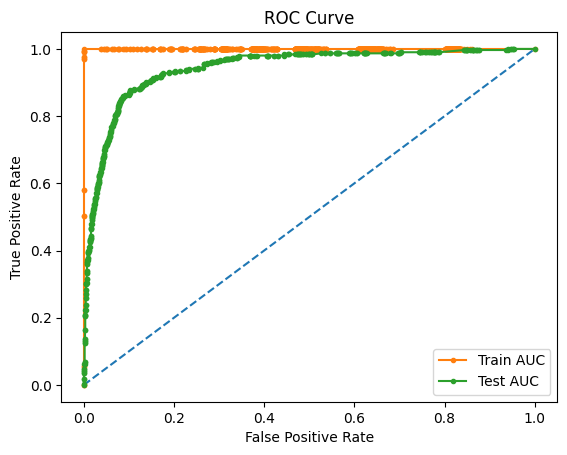

In [ ]:
model_RF = RandomForestClassifier(n_estimators=250, max_depth=25, class_weight='balanced', n_jobs=-1)
model_RF.fit(xtrain, ytrain)
y_probs_train = model_RF.predict_proba(xtrain)
y_probs_test = model_RF.predict_proba(xtest)
y_predicted_train = model_RF.predict(xtrain)
y_predicted_test = model_RF.predict(xtest)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_test = y_probs_test[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(ytrain, y_probs_train)
test_auc = roc_auc_score(ytest, y_probs_test)
train_acc = accuracy_score(ytrain, y_predicted_train)
test_acc = accuracy_score(ytest, y_predicted_test)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('Test AUC: %.3f' % test_auc)
print('*'*50)
print('Train Accuracy: %.3f' % train_acc)
print('Test Accuracy: %.3f' % test_acc)

score['Random Forest'] = [test_auc, test_acc]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(ytrain, y_probs_train)
test_fpr, test_tpr, test_thresholds = roc_curve(ytest, y_probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(test_fpr, test_tpr, marker='.', label='Test AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

<h3> XgBoost </h3>

In [ ]:
from xgboost import XGBClassifier

params = {'max_depth': [1,5, 10, 15], 'n_estimators': [5,10, 100, 500]}

model_XGBoost = XGBClassifier(class_weight='balanced', n_jobs=-1)
clf_XGBoost  = RandomizedSearchCV(model_XGBoost , param_distributions=params, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1, return_train_score=True)
clf_XGBoost .fit(xtrain, ytrain)
print('Best parameters:  {}'.format(clf_XGBoost .best_params_))
print('Best score: {}'.format(clf_XGBoost .best_score_))

[11:53:06] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

Best parameters:  {'n_estimators': 500, 'max_depth': 10}
Best score: 0.940625576204558


<h4>Training XgBoost with best hyperparameters </h4>

[11:54:42] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

**************************************************
Train AUC: 1.000
Test AUC: 1.000
**************************************************
Train Accuracy: 0.072
Test Accuracy: 0.074


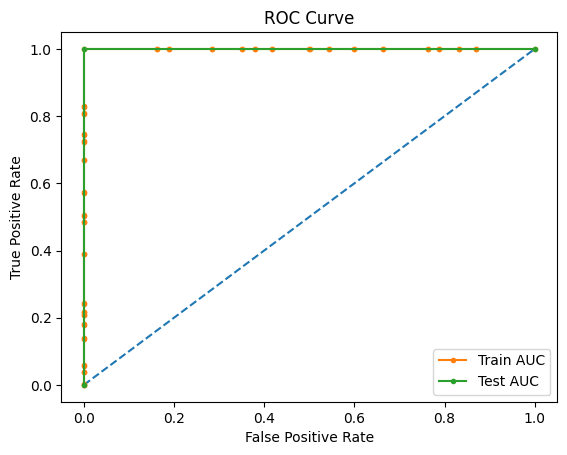

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

model_XGBoost = XGBClassifier(max_depth=15, n_estimators=500 ,class_weight='balanced', n_jobs=-1)
model_XGBoost.fit(xtrain, ytrain)
y_probs_train = model_XGBoost.predict_proba(xtrain)
y_probs_test = model_XGBoost.predict_proba(ytest)
y_predicted_train = model_XGBoost.predict(ytrain)
y_predicted_test = model_XGBoost.predict(ytest)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_test = y_probs_test[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(ytrain, y_probs_train)
test_auc = roc_auc_score(ytest, y_probs_test)
train_acc = accuracy_score(ytrain, y_predicted_train)
test_acc = accuracy_score(ytest, y_predicted_test)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('Test AUC: %.3f' % test_auc)
print('*'*50)
print('Train Accuracy: %.3f' % train_acc)
print('Test Accuracy: %.3f' % test_acc)

score['XGBoost'] = [test_auc, test_acc]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(ytrain, y_probs_train)
test_fpr, test_tpr, test_thresholds = roc_curve(ytest, y_probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(test_fpr, test_tpr, marker='.', label='Test AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
!pip install ampligraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.utils import save_model, restore_model

model = ScoringBasedEmbeddingModel(# batches_count=100, 
                seed=0, 
                # epochs=200,
                k=300, 
                eta=5, 
                scoring_type='ComplEx')
model.compile(optimizer='adam',
              optimizer_params={'lr':1e-3}, 
              loss='multiclass_nll',    # Multiclass NLL Loss Reference: https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.NLLMulticlass.html#ampligraph.latent_features.NLLMulticlass
              regularizer='LP',
              regularizer_params={'p':3,'lambda':1e-2},
              verbose=True) # The nuclear 3-norm proposed in the ComplEx-N3 from paper LUO18, proves to be effective for DistMult and ComplEx Reference: https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding/issues/6 

In [ ]:
# Early Stopping callback
checkpoint = tf.keras.callbacks.EarlyStopping(
    monitor='val_{}'.format('hits10'),
    min_delta=0,
    patience=5,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

In [ ]:
import tensorflow as tf
import time
# tf.logging.set_verbosity(tf.logging.ERROR)
start_time = time.time()
# model.fit(df, early_stopping = False)
model.fit(xtrain, callbacks=[checkpoint])
print("Execution time: %s seconds." % (time.time() - start_time))

Data shape is 100: not only triples were given, but focusE is not active!
   4950/Unknown - 1842s 372ms/step - loss: 1.7918

In [ ]:
# Save the model
example_name = "/content/ComplEx_Model.pkl"
save_model(model, model_name_path=example_name)

# Restore the model
restored_model = restore_model(model_name_path=example_name)

<h2> Conclusion </h2>

* It was a great learning experience working on a social media dataset.

* Our dataset consist of categorical and numerical features.     

* We have 2 independent features, out of these only half of them are important.   

* Perform  Exploratory Data Analysis (EDA) on nodes and edges with the help of networkx package and find the relation betweem them.     

* Different machine learning models are trained and tested on the dataset. Out of those Random forest performs best. XGBoost is also an important model as it results in high AUC score.    

* Different models are summarized in table below.              

In [ ]:
print('***************  Comparison of different models  ****************')
table = PrettyTable(['Model', 'Test AUC', 'Test Accuracy'])
for item in score.items():
    table.add_row([item[0], item[1][0], item[1][1]])
print(table)

In [ ]:
from prettytable.colortable import ColorTable, Themes

# x = ColorTable(theme=Themes.OCEAN)

# print(x)

print('***************  Comparison of different models  ****************')
table = ColorTable(['Model', 'Test AUC', 'Test Accuracy'],theme=Themes.OCEAN)
for item in score.items():
    table.add_row([item[0], item[1][0], item[1][1]])
print(table)

## Approach

In order to optimize link prediction of from social media network with the help of the dataset, we will have to take the following steps:

* Download the dataset from the https://networkrepository.com/fb-pages-food.php.
* Import data from dataset and perform initial high-level analysis:
    look at the number of rows,look at the missing values, look at dataset columns and their values respective to the prediction outcome.
* Clean the data: remove irrelevant columns, deal with missing and incorrect values if present in dataset
* Preprocessing
* Train Test Split 
* Use machine learning techniques to predict future friend outcome and to find out factors, which affect the success of the prediction.

<h2> References/Citations </h2>                         

1. https://paperswithcode.com/task/link-prediction.  

2. https://networkrepository.com/fb-pages-food.php.  

3. https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/                   